In [139]:
from __future__ import print_function
import numpy as np    
import csv
import copy
import random
import pandas
import matplotlib.pyplot as plt

#import mlpy
#from mlpy import KernelRidge

import sklearn
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared









Below, the DFT data + set of descriptors is read from a Data.csv file. Every data point is an impurity atom + defect site + CdX compound + DFT computed set of properties + complete set of descriptors. There are 3 DFT properties here: formation energy at Cd-rich, intermediate, and anion-rich chemical potential conditions. 1st set of descriptors is from column 7 to column 20, 2nd set of descriptors is from column 21 to column 25, and the complete set of descriptors is when columns 7 to 25 are used. Two further .csv files are read: Outside.csv which contains additional DFT computations performed on new compounds (CdTeSe and CdSeS alloys) and X.csv which contains descriptors for thousands of possible data points that make up the chemical space, about 25% of which were used to generate the DFT dataset.

In [140]:
##  Read Data  ##

ifile  = open('Data.csv', "rt")
#ifile  = open('Data_norm.csv', "rt")
reader = csv.reader(ifile)
csvdata=[]
for row in reader:
        csvdata.append(row)   
ifile.close()
numrow=len(csvdata)
numcol=len(csvdata[0]) 
csvdata = np.array(csvdata).reshape(numrow,numcol)
dopant = csvdata[:,0]
CdX = csvdata[:,1]
doping_site = csvdata[:,2]
prop  = csvdata[:,3]  ## Cd-rich Delta_H
#prop  = csvdata[:,4]  ## Mod. Delta_H
#prop  = csvdata[:,5]  ## X-rich Delta_H
#X = csvdata[:,6:20]
#X = csvdata[:,20:25]
X = csvdata[:,6:]



    # Read CdX alloy data: CdTe_0.5Se_0.5 and CdSe_0.5S_0.5
ifile2  = open('Outside.csv', "rt")
#ifile2  = open('Outside_norm.csv', "rt")
reader2 = csv.reader(ifile2)
csvdata2=[]
for row2 in reader2:
        csvdata2.append(row2)
ifile2.close()
numrow2=len(csvdata2)
numcol2=len(csvdata2[0])
csvdata2 = np.array(csvdata2).reshape(numrow2,numcol2)
dopant_out = csvdata2[:,0]
CdX_out = csvdata2[:,1]
doping_site_out = csvdata2[:,2]
prop_out  = csvdata2[:,3]
#prop_out  = csvdata2[:,4]
#prop_out  = csvdata2[:,5]
#X_out = csvdata2[:,6:20]
#X_out = csvdata2[:,20:25]
X_out = csvdata2[:,6:]

n_out = prop_out.size


    # Read Entire Dataset                                                                                                              
ifile3  = open('X.csv', "rt")
#ifile3  = open('X_norm.csv', "rt")
reader3 = csv.reader(ifile3)
csvdata3=[]
for row3 in reader3:
        csvdata3.append(row3)
ifile3.close()
numrow3=len(csvdata3)
numcol3=len(csvdata3[0])
csvdata3 = np.array(csvdata3).reshape(numrow3,numcol3)
dopant_all = csvdata3[:,0]
CdX_all = csvdata3[:,1]
doping_site_all = csvdata3[:,2]
#X_all = csvdata3[:,3:17]
#X_all = csvdata3[:,17:22]
X_all = csvdata3[:,3:]

n_all = dopant_all.size





Below, the dataset is divided into a training and test set. Applying t = 0.2 creates an 80-20 training-test split; change t for a different split.

In [141]:


##  Train-Test Split  ##

XX = copy.deepcopy(X)
n = dopant.size
m = np.int(X.size/n)

t = 0.20

X_train, X_test, Prop_train, Prop_test, dop_train, dop_test, sc_train, sc_test, ds_train, ds_test = train_test_split(XX, prop, dopant, CdX, doping_site, test_size=t)

n_tr = Prop_train.size
n_te = Prop_test.size


Prop_train_fl = np.zeros(n_tr)
for i in range(0,n_tr):
    Prop_train_fl[i] = copy.deepcopy(float(Prop_train[i]))

Prop_test_fl = np.zeros(n_te)
for i in range(0,n_te):
    Prop_test_fl[i] = copy.deepcopy(float(Prop_test[i]))
    
X_train_fl = [[0.0 for a in range(m)] for b in range(n_tr)]
for i in range(0,n_tr):
    for j in range(0,m):
        X_train_fl[i][j] = np.float(X_train[i][j])

X_test_fl = [[0.0 for a in range(m)] for b in range(n_te)]
for i in range(0,n_te):
    for j in range(0,m):
        X_test_fl[i][j] = np.float(X_test[i][j])



        
        


ML1: Define random forest regressor with default parameters which fits a model to the training data and makes predictions on the test dataset. Print out the training and test predictions as .csv or .txt files if desired.

Comment if ML2 or ML3 are being used, un-comment if ML1 needs to be used.

In [73]:
        
        
        

        
###   Random Forest 1st Run   ###




##  Train Random Forest Model  ##


rfreg_opt = RandomForestRegressor(bootstrap=True, criterion='mae')

rfreg_opt.fit(X_train,Prop_train)
Pred_train = rfreg_opt.predict(X_train)
Pred_test  = rfreg_opt.predict(X_test)
Pred_train_fl = [0.0]*(Pred_train.size)
Pred_test_fl = [0.0]*(Pred_test.size)
for i in range(0,Pred_train.size):
    Pred_train_fl[i] = np.float(Pred_train[i])
for i in range(0,Pred_test.size):
    Pred_test_fl[i] = np.float(Pred_test[i])
    
#np.savetxt('Pred_train.csv', Pred_train_fl)
#np.savetxt('Pred_test.csv', Pred_test_fl)
    
    
    
    


ML2: Perform hyperparameter optimization when training random forest regression model. I define 5 hyperparameters to be tuned: number of estimators (number of trees in the forest), maximum depth of a tree, maximum features considered when looking for the best split, minimum number of samples required at a leaf node, and minimum number of samples required to split an internal node. All or some of these hyperparameters may be optimized by changing the rfregs_all definition loop. The random forest training loop runs over the length of rfregs_all and trains different RF models; the set of hyperparameters leading to minimum test error is taken as the optimal RF regressor, or rfreg_opt. Print out the training and test predictions as .csv or .txt files if desired.

Comment if ML1 or ML3 are being used, un-comment if ML2 needs to be used.

In [ ]:
    
    
    
###   Random Forest 2nd Run   ###



  ##  Set of RF Model Parameters  ##

    

rfregs_all = list()

n_est_all = [50, 100, 200]
max_depth_all = [40, 70, 100]
max_feat_all = [10, 15, m]
min_samp_leaf_all = [1, 3, 5]
min_samp_split_all = [2, 5, 10]

for i in range(0,3):
    for j in range(0,3):
        for k in range(0,3):
            for l in range(0,3):
#                for h in range(0,3):
#        rfreg_temp = RandomForestRegressor(bootstrap=True, criterion='mae', n_estimators=n_est_all[i], max_depth=max_depth_all[j], max_features=15, min_samples_leaf=5, min_samples_split=10)
#        rfreg_temp = RandomForestRegressor(bootstrap=True, criterion='mae', n_estimators=100, max_depth=70, min_samples_leaf=min_samp_leaf_all[i], min_samples_split=min_samp_split_all[j], max_features=15)
#                    rfreg_temp = RandomForestRegressor(bootstrap=True, criterion='mae', n_estimators=n_est_all[i], max_depth=max_depth_all[j], min_samples_leaf=min_samp_leaf_all[k], min_samples_split=min_samp_split_all[l], max_features=max_feat_all[h])
                rfreg_temp = RandomForestRegressor(bootstrap=True, criterion='mae', n_estimators=n_est_all[i], max_depth=max_depth_all[j], min_samples_leaf=min_samp_leaf_all[k], min_samples_split=min_samp_split_all[l])
                rfregs_all.append(rfreg_temp)



##  Train Random Forest Model  ##


times = len(rfregs_all)

train_errors = [0.0]*times
test_errors = [0.0]*times

for k in range(0,times):
    rfreg = rfregs_all[k]
    rfreg.fit(X_train,Prop_train)
    Pred_train = rfreg.predict(X_train)
    Pred_test  = rfreg.predict(X_test)
    Pred_train_fl = [0.0]*(Pred_train.size)
    Pred_test_fl = [0.0]*(Pred_test.size)
    for i in range(0,Pred_train.size):
        Pred_train_fl[i] = np.float(Pred_train[i])
    for i in range(0,Pred_test.size):
        Pred_test_fl[i] = np.float(Pred_test[i])
    train_errors[k] = sklearn.metrics.mean_squared_error(Prop_train_fl, Pred_train_fl)
    test_errors[k] = sklearn.metrics.mean_squared_error(Prop_test_fl, Pred_test_fl)

i_opt = np.argmin(test_errors)
rfreg_opt = rfregs_all[i_opt]


rfreg_opt.fit(X_train,Prop_train)
Pred_train = rfreg_opt.predict(X_train)
Pred_test  = rfreg_opt.predict(X_test)
Pred_train_fl = [0.0]*(Pred_train.size)
Pred_test_fl = [0.0]*(Pred_test.size)
for i in range(0,Pred_train.size):
    Pred_train_fl[i] = np.float(Pred_train[i])
for i in range(0,Pred_test.size):
    Pred_test_fl[i] = np.float(Pred_test[i])








ML3: Perform hyperparameter optimization (same as ML2) + cross-validation (used to take care of overfitting in machine learning). Change n-fold to define the type of cross-validation (CV), for eg. 5-fold CV. The RF training loop once again runs over the length of rfregs_all but at every point, divides the training set into n folds, uses (n-1) sets to train the model and tests on the n-th set. The CV training and CV test errors are defined as averages over the n sets; the set of hyperparameters leading to minimum CV test error is taken as the optimal regressor rfreg_opt. Print out the training and test predictions as .csv or .txt files if desired.

Comment out if ML1 or ML2 are being used, un-comment if ML3 needs to be used.

In [124]:






# ###   Random Forest 3rd Run   ###


  ##  Set of RF Model Parameters  ##


rfregs_all = list()

#n_est_all = [50, 100, 200, 300, 500]
#max_depth_all = [30, 75, 100, 150, 200]

n_est_all = [50, 100, 200]
max_depth_all = [40, 70, 100]
max_feat_all = [5, 10, m]
min_samp_leaf_all = [1, 3, 5]
min_samp_split_all = [2, 5, 10]

for i in range(0,3):
    for j in range(0,3):
#        for k in range(0,3):
#            for l in range(0,3):
#                for h in range(0,3):
#        rfreg_temp = RandomForestRegressor(bootstrap=True, criterion='mae', n_estimators=n_est_all[i], max_depth=max_depth_all[j], max_features=15, min_samples_leaf=5, min_samples_split=10)
        rfreg_temp = RandomForestRegressor(bootstrap=True, criterion='mae', n_estimators=100, max_depth=70, min_samples_leaf=min_samp_leaf_all[i], min_samples_split=min_samp_split_all[j], max_features=m)
#                    rfreg_temp = RandomForestRegressor(bootstrap=True, criterion='mae', n_estimators=n_est_all[i], max_depth=max_depth_all[j], min_samples_leaf=min_samp_leaf_all[k], min_samples_split=min_samp_split_all[l], max_features=max_feat_all[h])
#                rfreg_temp = RandomForestRegressor(bootstrap=True, criterion='mae', n_estimators=n_est_all[i], max_depth=max_depth_all[j], min_samples_leaf=min_samp_leaf_all[k], min_samples_split=min_samp_split_all[l])
        rfregs_all.append(rfreg_temp)



##  Train Random Forest Model  ##


times = len(rfregs_all)

train_errors = [0.0]*times
test_errors = [0.0]*times


##  Cross-validation  ##

n_fold = 5

for i in range(0,times):
    kf = KFold(n_splits = n_fold)
    mse_test_cv = 0.00
    mse_train_cv = 0.00
    count = 0
    rfreg = rfregs_all[i]
    for train, test in kf.split(X_train):
        X_train_cv, X_test_cv, Prop_train_cv, Prop_test_cv = X_train[train], X_train[test], Prop_train[train], Prop_train[test]

        rfreg.fit(X_train_cv,Prop_train_cv)
        Prop_pred_train_cv = rfreg.predict(X_train_cv)
        Prop_pred_test_cv  = rfreg.predict(X_test_cv)

        n_tr_cv = Prop_train_cv.size
        n_te_cv = Prop_test_cv.size
        Prop_test_cv_fl = [0.0]*n_te_cv
        Prop_pred_test_cv_fl = [0.0]*n_te_cv
        Prop_train_cv_fl = [0.0]*n_tr_cv
        Prop_pred_train_cv_fl = [0.0]*n_tr_cv

        for a in range(0,n_tr_cv):
            Prop_train_cv_fl[a] = np.float(Prop_train_cv[a])
            Prop_pred_train_cv_fl[a] = np.float(Prop_pred_train_cv[a])
        for a in range(0,n_te_cv):
            Prop_test_cv_fl[a] = np.float(Prop_test_cv[a])
            Prop_pred_test_cv_fl[a] = np.float(Prop_pred_test_cv[a])

        mse_test_cv = mse_test_cv  + sklearn.metrics.mean_squared_error(Prop_test_cv_fl,Prop_pred_test_cv_fl)
        mse_train_cv = mse_train_cv + sklearn.metrics.mean_squared_error(Prop_train_cv_fl,Prop_pred_train_cv_fl)
    mse_test = mse_test_cv / n_fold
    mse_train = mse_train_cv / n_fold
    train_errors[i] = mse_train
    test_errors[i] = mse_test
i_opt = np.argmin(test_errors)
rfreg_opt = rfregs_all[i_opt]


rfreg_opt.fit(X_train,Prop_train)
Pred_train = rfreg_opt.predict(X_train)
Pred_test  = rfreg_opt.predict(X_test)
Pred_train_fl = [0.0]*(Pred_train.size)
Pred_test_fl = [0.0]*(Pred_test.size)
for i in range(0,Pred_train.size):
    Pred_train_fl[i] = np.float(Pred_train[i])
for i in range(0,Pred_test.size):
    Pred_test_fl[i] = np.float(Pred_test[i])


    
    
    
    


Kernel Ridge Regression with hyperparameter optimization using GridSearchCV.


In [114]:


##  Train Kernel Ridge Regression Model  ##


param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],
              "kernel": [ExpSineSquared(l, p)
                         for l in np.logspace(-2, 2, 10)
                         for p in np.logspace(0, 2, 10)]}
krr_opt = GridSearchCV(KernelRidge(), param_grid=param_grid)

#krr_opt = KernelRidge(alpha=1, kernel='linear', gamma=0.2, degree=3, coef0=1, kernel_params=None)

krr_opt.fit(X_train,Prop_train)
Pred_train = krr_opt.predict(X_train)
Pred_test  = krr_opt.predict(X_test)
Pred_train_fl = [0.0]*(Pred_train.size)
Pred_test_fl = [0.0]*(Pred_test.size)
for i in range(0,Pred_train.size):
    Pred_train_fl[i] = np.float(Pred_train[i])
for i in range(0,Pred_test.size):
    Pred_test_fl[i] = np.float(Pred_test[i])
    
#np.savetxt('Pred_train.csv', Pred_train_fl)
#np.savetxt('Pred_test.csv', Pred_test_fl)



/Users/mannodiarun/gsas2full/lib/python3.7/site-packages/sklearn/utils/validation.py:755: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  estimator=estimator)


In [ ]:
Random Forest Regression with hyperparameter optimization using GridSearchCV.

In [142]:
param_grid = {"n_estimators": [50, 100, 200],
              "max_depth": [40, 70, 100],
              "max_features": [10, 15, m],
              "min_samples_leaf": [1, 3, 5],
              "min_samples_split": [2, 5, 10]}

rfregs_opt = GridSearchCV(RandomForestRegressor(), param_grid=param_grid)

rfreg_opt.fit(X_train,Prop_train)
Pred_train = rfreg_opt.predict(X_train)
Pred_test  = rfreg_opt.predict(X_test)
Pred_train_fl = [0.0]*(Pred_train.size)
Pred_test_fl = [0.0]*(Pred_test.size)
for i in range(0,Pred_train.size):
    Pred_train_fl[i] = np.float(Pred_train[i])
for i in range(0,Pred_test.size):
    Pred_test_fl[i] = np.float(Pred_test[i])




Use the optimal RF model, rfreg_opt, as trained using ML1, ML2 or ML3, to make predictions on (a) the outside dataset, which contains additional DFT data generated for CdTeSe and CdSeS compounds (which were not included at all in Data.csv, the file used for training and testing the regression models), and (b) the entire chemical space, which contains all the DFT data points + the missing data points which make up ~ 75% of the total data points. Print out the predictions as .csv or .txt files if desired.

In [143]:
    
    
    
    
###    Outside Prediction    ###


Pred_out = rfreg_opt.predict(X_out)
#Pred_out = krr_opt.predict(X_out)
Pred_out_fl = [0.0]*Pred_out.size
Prop_out_fl = [0.0]*Pred_out.size
for i in range(0,prop_out.size):
    Prop_out_fl[i] = np.float(prop_out[i])
for i in range(0,prop_out.size):
    Pred_out_fl[i] = np.float(Pred_out[i])

#np.savetxt('Pred_out.csv', Pred_out_fl)



Pred_all = rfreg_opt.predict(X_all)
#Pred_all = krr_opt.predict(X_all)
Pred_all_fl = [0.0]*Pred_all.size
for i in range(0,Pred_all.size):
    Pred_all_fl[i] = np.float(Pred_all[i])

#np.savetxt('Pred_all.csv', Pred_all_fl)




    

    


If error bars are desired, they can be calculated based on the standard deviation of predictions from across the different estimators or trees in the forest. Change the percentile from 95 if needed. Error bars are estimated based on the RF predictors for the training, test, outside and entire datasets.

Comment out this section if errors are not desired.

In [144]:
    


##  Error Bars of Training and Test Datasets  ##


percentile = 95


err_up_train   = [0.0]*n_tr
err_down_train = [0.0]*n_tr
preds_fl = [[0.0 for a in range(n_tr)] for b in range (len(rfreg_opt.estimators_))]
z = 0

for pred in rfreg_opt.estimators_:
    preds = pred.predict(X_train)
    for i in range(0,n_tr):
        preds_fl[z][i] = np.float(preds[i])
    z = z+1

pp = [0.0]*len(rfreg_opt.estimators_)
for i in range(n_tr):
    for j in range(0,len(rfreg_opt.estimators_)):
        pp[j] = preds_fl[j][i]
    err_down_train[i] = np.percentile(pp[:], (100 - percentile) / 2. )
    err_up_train[i] = np.percentile(pp[:], 100 - (100 - percentile) / 2.)



err_up_test   = [0.0]*n_te
err_down_test = [0.0]*n_te
preds_fl = [[0.0 for a in range(n_te)] for b in range (len(rfreg_opt.estimators_))]
z = 0

for pred in rfreg_opt.estimators_:
    preds = pred.predict(X_test)
    for i in range(0,n_te):
        preds_fl[z][i] = np.float(preds[i])
    z = z+1

pp = [0.0]*len(rfreg_opt.estimators_)
for i in range(n_te):
    for j in range(0,len(rfreg_opt.estimators_)):
        pp[j] = preds_fl[j][i]
    err_down_test[i] = np.percentile(pp[:], (100 - percentile) / 2. )
    err_up_test[i] = np.percentile(pp[:], 100 - (100 - percentile) / 2.)


#np.savetxt('up_train.csv', err_up_train)
#np.savetxt('down_train.csv', err_down_train)
#np.savetxt('up_test.csv', err_up_test)
#np.savetxt('down_test.csv', err_down_test)



    
    
    
    
    
    
    
###     Error Bars on Outside Dataset    ###
    
    
    
err_up_out = [0.0]*n_out
err_down_out = [0.0]*n_out
preds_fl = [[0.0 for a in range(n_out)] for b in range (len(rfreg_opt.estimators_))]
z = 0

for pred in rfreg_opt.estimators_:
    preds = pred.predict(X_out)
    for i in range(0,n_out):
        preds_fl[z][i] = np.float(preds[i])
    z = z+1

pp = [0.0]*len(rfreg_opt.estimators_)
for i in range(n_out):
    for j in range(0,len(rfreg_opt.estimators_)):
        pp[j] = preds_fl[j][i]
    err_down_out[i] = np.percentile(pp[:], (100 - percentile) / 2. )
    err_up_out[i] = np.percentile(pp[:], 100 - (100 - percentile) / 2.)


up_out = [0.0]*n_out
down_out = [0.0]*n_out

for i in range(0,n_out):
    up_out[i] = err_up_out[i] - Pred_out_fl[i]
    down_out[i] = Pred_out_fl[i] - err_down_out[i]


#np.savetxt('up_out.csv', up_out)
#np.savetxt('down_out.csv', down_out)




    
    
    
    
###     Error Bars for Entire Chemical Space    ###


err_up_all = [0.0]*n_all
err_down_all = [0.0]*n_all
preds_fl = [[0.0 for a in range(n_all)] for b in range (len(rfreg_opt.estimators_))]
z = 0

for pred in rfreg_opt.estimators_:
    preds = pred.predict(X_all)
    for i in range(0,n_all):
        preds_fl[z][i] = np.float(preds[i])
    z = z+1

pp = [0.0]*len(rfreg_opt.estimators_)
for i in range(n_all):
    for j in range(0,len(rfreg_opt.estimators_)):
        pp[j] = preds_fl[j][i]
    err_down_all[i] = np.percentile(pp[:], (100 - percentile) / 2. )
    err_up_all[i] = np.percentile(pp[:], 100 - (100 - percentile) / 2.)


up_all = [0.0]*n_all
down_all = [0.0]*n_all

for i in range(0,n_all):
    up_all[i] = err_up_all[i] - Pred_all_fl[i]
    down_all[i] = Pred_all_fl[i] - err_down_all[i]



#np.savetxt('up_all.csv', up_all)
#np.savetxt('down_all.csv', down_all)














Divide actual and predicted data by CdX compound type (CdTe or CdSe or CdS).

In [145]:



##  Predicted Data by Type of CdX Compound  ##


Prop_train_CdTe = [0.0]*len(Prop_train_fl)
err_up_train_CdTe = copy.deepcopy(err_up_train)
err_down_train_CdTe = copy.deepcopy(err_down_train)

Prop_train_CdSe = [0.0]*len(Prop_train_fl)
err_up_train_CdSe = copy.deepcopy(err_up_train)
err_down_train_CdSe = copy.deepcopy(err_down_train)

Prop_train_CdS = [0.0]*len(Prop_train_fl)
err_up_train_CdS = copy.deepcopy(err_up_train)
err_down_train_CdS = copy.deepcopy(err_down_train)

Prop_test_CdTe = [0.0]*len(Prop_test_fl)
err_up_test_CdTe = copy.deepcopy(err_up_test)
err_down_test_CdTe = copy.deepcopy(err_down_test)

Prop_test_CdSe = [0.0]*len(Prop_test_fl)
err_up_test_CdSe = copy.deepcopy(err_up_test)
err_down_test_CdSe = copy.deepcopy(err_down_test)

Prop_test_CdS = [0.0]*len(Prop_test_fl)
err_up_test_CdS = copy.deepcopy(err_up_test)
err_down_test_CdS = copy.deepcopy(err_down_test)


Pred_train_CdTe = [0.0]*len(Pred_train_fl)
Pred_train_CdSe = [0.0]*len(Pred_train_fl)
Pred_train_CdS = [0.0]*len(Pred_train_fl)
Pred_test_CdTe = [0.0]*len(Pred_test_fl)
Pred_test_CdSe = [0.0]*len(Pred_test_fl)
Pred_test_CdS = [0.0]*len(Pred_test_fl)



aa = 0
bb = 0
cc = 0
dd = 0
ee = 0
ff = 0
gg = 0
hh = 0
ii = 0
jj = 0
kk = 0
ll = 0

for i in range(0,Prop_train_fl.size):
    if sc_train[i] == 'CdTe':
        Prop_train_CdTe[aa] = Prop_train_fl[i]
        Pred_train_CdTe[aa] = Pred_train_fl[i]
        err_up_train_CdTe[aa] = err_up_train[i]
        err_down_train_CdTe[aa] = err_down_train[i]
        aa = aa+1
    if sc_train[i] == 'CdSe':
        Prop_train_CdSe[bb] = Prop_train_fl[i]
        Pred_train_CdSe[bb] = Pred_train_fl[i]
        err_up_train_CdSe[bb] = err_up_train[i]
        err_down_train_CdSe[bb] = err_down_train[i]
        bb = bb+1
    if sc_train[i] == 'CdS':
        Prop_train_CdS[cc] = Prop_train_fl[i]
        Pred_train_CdS[cc] = Pred_train_fl[i]
        err_up_train_CdS[cc] = err_up_train[i]
        err_down_train_CdS[cc] = err_down_train[i]
        cc = cc+1

for i in range(0,Prop_test_fl.size):
    if sc_test[i] == 'CdTe':
        Prop_test_CdTe[dd] = Prop_test_fl[i]
        Pred_test_CdTe[dd] = Pred_test_fl[i]
        err_up_test_CdTe[dd] = err_up_test[i]
        err_down_test_CdTe[dd] = err_down_test[i]
        dd = dd+1
    if sc_test[i] == 'CdSe':
        Prop_test_CdSe[ee] = Prop_test_fl[i]
        Pred_test_CdSe[ee] = Pred_test_fl[i]
        err_up_test_CdSe[ee] = err_up_test[i]
        err_down_test_CdSe[ee] = err_down_test[i]
        ee = ee+1
    if sc_test[i] == 'CdS':
        Prop_test_CdS[ff] = Prop_test_fl[i]
        Pred_test_CdS[ff] = Pred_test_fl[i]
        err_up_test_CdS[ff] = err_up_test[i]
        err_down_test_CdS[ff] = err_down_test[i]
        ff = ff+1



up_train_CdTe = [0.0]*aa
down_train_CdTe = [0.0]*aa
up_test_CdTe = [0.0]*dd
down_test_CdTe = [0.0]*dd

up_train_CdSe = [0.0]*bb
down_train_CdSe = [0.0]*bb
up_test_CdSe = [0.0]*ee
down_test_CdSe = [0.0]*ee

up_train_CdS = [0.0]*cc
down_train_CdS = [0.0]*cc
up_test_CdS = [0.0]*ff
down_test_CdS = [0.0]*ff


for i in range(0,aa):
    up_train_CdTe[i]   = err_up_train_CdTe[i] - Pred_train_CdTe[i]
    down_train_CdTe[i] = Pred_train_CdTe[i] - err_down_train_CdTe[i]
for i in range(0,bb):
    up_train_CdSe[i] = err_up_train_CdSe[i] - Pred_train_CdSe[i]
    down_train_CdSe[i] = Pred_train_CdSe[i] - err_down_train_CdSe[i]
for i in range(0,cc):
    up_train_CdS[i] = err_up_train_CdS[i] - Pred_train_CdS[i]
    down_train_CdS[i] = Pred_train_CdS[i] - err_down_train_CdS[i]



for i in range(0,dd):
    up_test_CdTe[i] = err_up_test_CdTe[i] - Pred_test_CdTe[i]
    down_test_CdTe[i] = Pred_test_CdTe[i] - err_down_test_CdTe[i]
for i in range(0,ee):
    up_test_CdSe[i] = err_up_test_CdSe[i] - Pred_test_CdSe[i]
    down_test_CdSe[i] = Pred_test_CdSe[i] - err_down_test_CdSe[i]
for i in range(0,ff):
    up_test_CdS[i] = err_up_test_CdS[i] - Pred_test_CdS[i]
    down_test_CdS[i] = Pred_test_CdS[i] - err_down_test_CdS[i]




    
    


Print out prediction root mean square errors for training, test and outside points.

In [146]:




##  Calculate Prediction RMSE  ##


rmse_test_prop = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_test_fl, Pred_test_fl) )
rmse_train_prop = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_train_fl, Pred_train_fl) )
print('rmse_test_prop=', rmse_test_prop)
print('rmse_train_prop=', rmse_train_prop)

rmse_test_CdTe = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_test_CdTe[0:dd], Pred_test_CdTe[0:dd]) )
rmse_train_CdTe = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_train_CdTe[0:aa], Pred_train_CdTe[0:aa]) )
print('rmse_test_CdTe=', rmse_test_CdTe)
print('rmse_train_CdTe=', rmse_train_CdTe)

rmse_test_CdSe = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_test_CdSe[0:ee], Pred_test_CdSe[0:ee]) )
rmse_train_CdSe = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_train_CdSe[0:bb], Pred_train_CdSe[0:bb]) )
print('rmse_test_CdSe=', rmse_test_CdSe)
print('rmse_train_CdSe=', rmse_train_CdSe)

rmse_test_CdS = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_test_CdS[0:ff], Pred_test_CdS[0:ff]) )
rmse_train_CdS = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_train_CdS[0:cc], Pred_train_CdS[0:cc]) )
print('rmse_test_CdS=', rmse_test_CdS)
print('rmse_train_CdS=', rmse_train_CdS)

rmse_CdTeSe = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_out_fl[0:22], Pred_out_fl[0:22]) )
rmse_CdSeS = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_out_fl[22:44], Pred_out_fl[22:44]) )
print('rmse_test_CdTeSe=', rmse_CdTeSe)
print('rmse_train_CdSeS=', rmse_CdSeS)
rmse_out = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_out_fl[0:44], Pred_out_fl[0:44]) )











rmse_test_prop= 0.34131633180275894
rmse_train_prop= 0.1418225923082115
rmse_test_CdTe= 0.29319182867194626
rmse_train_CdTe= 0.12149819624381224
rmse_test_CdSe= 0.38954432615263707
rmse_train_CdSe= 0.14226719173663668
rmse_test_CdS= 0.3391724354485147
rmse_train_CdS= 0.15917332120741864
rmse_test_CdTeSe= 0.5220255430314423
rmse_train_CdSeS= 0.5698320738992484


Plot regression results as DFT vs ML parity plots; comment out error bars if not desired.

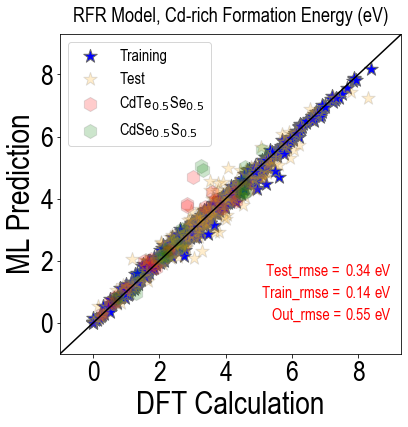

In [147]:




##  Plot Regression Results  ##


plt.figure(figsize=(6,6))
plt.subplots_adjust(left=0.16, bottom=0.16, right=0.95, top=0.90)
plt.rc('font', family='Arial narrow')

plt.title('RFR Model, Cd-rich Formation Energy (eV)', fontsize=20, pad=12)
#plt.title('KRR Model, Cd-rich Formation Energy (eV)', fontsize=20, pad=12)

a = [-175,0,125]
b = [-175,0,125]
plt.plot(b, a, c='k', ls='-')

plt.ylabel('ML Prediction', fontname='Arial Narrow', size=32)
plt.xlabel('DFT Calculation', fontname='Arial Narrow', size=32)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.ylim([-1.0, 9.3])
plt.xlim([-1.0, 9.3])

#plt.scatter(Prop_train_CdTe[:], Pred_train_CdTe[:], c='blue', marker='s', s=100, edgecolors='dimgrey', alpha=1.0, label='Training')
#plt.scatter(Prop_train_CdSe[:], Pred_train_CdSe[:], c='blue',marker='^', s=150, edgecolors='dimgrey', alpha=1.0, label='_nolegend_')
#plt.scatter(Prop_train_CdS[:], Pred_train_CdS[:], c='blue', marker='*', s=200, edgecolors='dimgrey', alpha=1.0, label='_nolegend_')
#plt.scatter(Prop_test_CdTe[:], Pred_test_CdTe[:], c='orange', marker='s', s=100, edgecolors='dimgrey', alpha=0.2, label='Test')
#plt.scatter(Prop_test_CdSe[:], Pred_test_CdSe[:], c='orange', marker='^', s=150, edgecolors='dimgrey', alpha=0.2, label='_nolegend_')
#plt.scatter(Prop_test_CdS[:], Pred_test_CdS[:], c='orange', marker='*', s=200, edgecolors='dimgrey', alpha=0.2, label='_nolegend_')

plt.scatter(Prop_train_fl[:], Pred_train_fl[:], c='blue', marker='*', s=200, edgecolors='dimgrey', alpha=1.0, label='Training')
plt.scatter(Prop_test_fl[:], Pred_test_fl[:], c='orange', marker='*', s=200, edgecolors='dimgrey', alpha=0.2, label='Test')

plt.scatter(Prop_out_fl[0:22], Pred_out_fl[0:22], c='red', marker='h', s=200, edgecolors='dimgrey', alpha=0.2, label='CdTe$_{0.5}$Se$_{0.5}$')
plt.scatter(Prop_out_fl[22:44], Pred_out_fl[22:44], c='green', marker='h', s=200, edgecolors='dimgrey', alpha=0.2, label='CdSe$_{0.5}$S$_{0.5}$')

# plt.errorbar(Prop_train_CdTe[0:aa], Pred_train_CdTe[0:aa], yerr = [up_train_CdTe[0:aa], down_train_CdTe[0:aa]], c='blue', marker='s', alpha=1.0, markeredgecolor='dimgrey', markersize=8, fmt='o', ecolor='blue', capthick=1, label='Training')
# plt.errorbar(Prop_train_CdSe[0:bb], Pred_train_CdSe[0:bb], yerr = [up_train_CdSe[0:bb], down_train_CdSe[0:bb]], c='blue', marker='^', alpha=1.0, markeredgecolor='dimgrey', markersize=8, fmt='o', ecolor='blue', capthick=1, label='_nolegend_')
# plt.errorbar(Prop_train_CdS[0:cc], Pred_train_CdS[0:cc], yerr = [up_train_CdS[0:cc], down_train_CdS[0:cc]], c='blue', marker='*', alpha=1.0, markeredgecolor='dimgrey', markersize=12, fmt='o', ecolor='blue', capthick=1, label='_nolegend_')

# plt.errorbar(Prop_test_CdTe[0:dd], Pred_test_CdTe[0:dd], yerr = [up_test_CdTe[0:dd], down_test_CdTe[0:dd]], c='orange', marker='s', alpha=0.2, markeredgecolor='dimgrey', markersize=8, fmt='o', ecolor='orange', capthick=1, label='Test')
# plt.errorbar(Prop_test_CdSe[0:ee], Pred_test_CdSe[0:ee], yerr = [up_test_CdSe[0:ee], down_test_CdSe[0:ee]], c='orange', marker='^', alpha=0.2, markeredgecolor='dimgrey', markersize=8, fmt='o', ecolor='orange', capthick=1, label='_nolegend_')
# plt.errorbar(Prop_test_CdS[0:ff], Pred_test_CdS[0:ff], yerr = [up_test_CdS[0:ff], down_test_CdS[0:ff]], c='orange', marker='*', alpha=0.2, markeredgecolor='dimgrey', markersize=12, fmt='o', ecolor='orange', capthick=1, label='_nolegend_')

# plt.errorbar(Prop_out_fl[0:22], Pred_out_fl[0:22], yerr = [up_out[0:22], down_out[0:22]], c='red', marker='h', alpha=0.2, markeredgecolor='dimgrey', markersize=8, fmt='o', ecolor='red', capthick=1, label='CdTe$_{0.5}$Se$_{0.5}$')
# plt.errorbar(Prop_out_fl[22:44], Pred_out_fl[22:44], yerr = [up_out[22:44], down_out[22:44]], c='green', marker='h', alpha=0.2, markeredgecolor='dimgrey', markersize=8, fmt='o', ecolor='green', capthick=1, label='CdSe$_{0.5}$S$_{0.5}$')


te = '%.2f' % rmse_test_prop
tr = '%.2f' % rmse_train_prop
out = '%.2f' % rmse_out

plt.text(5.2, 1.5, 'Test_rmse = ', c='r', fontsize=16)
plt.text(7.6, 1.5, te, c='r', fontsize=16)
plt.text(8.5, 1.5, 'eV', c='r', fontsize=16)
plt.text(5.1, 0.8, 'Train_rmse = ', c='r', fontsize=16)
plt.text(7.6, 0.8, tr, c='r', fontsize=16)
plt.text(8.5, 0.8, 'eV', c='r', fontsize=16)
plt.text(5.4, 0.1, 'Out_rmse = ', c='r', fontsize=16)
plt.text(7.6, 0.1, out, c='r', fontsize=16)
plt.text(8.5, 0.1, 'eV', c='r', fontsize=16)

plt.xticks([0, 2, 4, 6, 8])
plt.yticks([0, 2, 4, 6, 8])
plt.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'Arial narrow','size':16})
plt.savefig('plot_Cd_rich.pdf', dpi=450)

